In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt

from NeuralNMF import Neural_NMF, Energy_Loss_Func, L21_Norm, Recon_Loss_Func
from NeuralNMF import LsqNonneg
from NeuralNMF import train_unsupervised, train_supervised
#
import torch.nn as nn
from NeuralNMF import Writer

from time import time

import re

from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

## Loading and Preprocessing 20 Newsgroup Dataset

In [2]:
remove = ('headers','footers','quotes')
stopwords_list = stopwords.words('english')
stopwords_list.extend(['thanks','edu','also','would','one','could','please','really','many','anyone','good','right','get','even','want','must','something','well','much','still','said','stay','away','first','looking','things','try','take','look','make','may','include','thing','like','two','or','etc','phone','oh','email'])

categories = [
 'comp.graphics',
 'comp.sys.mac.hardware',
 'misc.forsale',
 'rec.motorcycles',
 'rec.sport.baseball',
 'sci.med',
 'sci.space',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.religion.misc'
 ]


directory = "categories_5" #this is 100 per class

newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)

# remove numbers
data_cleaned = [re.sub(r'\d+','', file) for file in newsgroups_train.data]

vectorizer = TfidfVectorizer(stop_words=stopwords_list)
vectors = vectorizer.fit_transform(data_cleaned).transpose()
idx_to_word = np.array(vectorizer.get_feature_names())

X = vectors
d, n = np.shape(X)

Y = np.zeros((n))

labels = {0:0, 1:0, 2:1, 3:2, 4:2, 5:3, 6:3, 7:4, 8:4, 9:5}

for i in range(n-1):
    label = newsgroups_train.target[i]
    Y[i] = label

X = torch.from_numpy(X.todense())
Y = torch.from_numpy(Y).long()

m = X.shape[0]
k1 = 10
k2 = 6


sub = 100 #HOW MANY PER CLASS
count = np.zeros((k1))

X_new = torch.zeros((X.shape[0], sub*k1))
Y_new = torch.zeros((sub*k1))
j = 0
for i in range(Y.shape[0]):
    if(count[Y[i]] >= sub):
        continue
    count[Y[i]] += 1
    X_new[:,j] = X[:,i]
    Y_new[j] = labels[int(Y[i])]
    j += 1

X = X_new.double()
Y = Y_new.long()

ind = np.argsort(Y)
X = X[:,ind]
Y = Y[ind]

split = 0.75
L = torch.zeros((k2, Y.shape[0])).double()
for i in range(len(categories)):
    L[:,i*sub:i*sub+(int(split*sub))] = 1

In [3]:
Y_mat = torch.zeros((6,Y.shape[0]))
r = np.arange(Y.shape[0])
Y_mat[[Y,r]] = 1
Y_mat = Y_mat.double()

In [4]:
lambd=1e-6
optimizer="gd"
lr = 1e10

epoch = 100
weight_decay=0.995

loss_func = Energy_Loss_Func(lambd=lambd) 

all_results = []

for _ in range(10):
    
    net = Neural_NMF([m, k1, k2], k2)

    start = time()

    history_supervised = train_supervised(net, X, Y, loss_func=loss_func, L=L, epoch = epoch, lr = lr, weight_decay=weight_decay, decay_epoch=5, optimizer=optimizer, full_history=True, verbose=True)

    end = time()

    print("Training time: {}".format(end-start))

    

    A1_lst = history_supervised.get('A1')
    S1_lst = history_supervised.get('S1')
    S2_lst = history_supervised.get('S2')

    A2 = history_supervised.get('A2')[-1]

    A1 = A1_lst[-1]
    S1 = S1_lst[-1]
    S2 = S2_lst[-1]


    results = {}
    results['X'] = X.detach().numpy()
    results['Y'] = Y.detach().numpy()
    results['A1'] = A1.detach().numpy()
    results['S1'] = S1.detach().numpy()
    results['A2'] = A2.detach().numpy()
    results['S2'] = S2.detach().numpy()
    results['words'] = idx_to_word
    results['loss_nmf'] = np.asarray([float(x) for x in history_supervised.get('loss_nmf')])
    results['loss_classification'] = np.asarray([float(x) for x in history_supervised.get('loss_classification')])

    all_results.append(results)
    
    np.save("supervsed_results_all", all_results)

100%|██████████| 100/100 [44:23<00:00, 26.63s/it]


Training time: 2663.381730079651


100%|██████████| 100/100 [30:54<00:00, 18.54s/it]


Training time: 1854.2989988327026


100%|██████████| 100/100 [32:44<00:00, 19.64s/it]


Training time: 1964.4072020053864


100%|██████████| 100/100 [3:43:27<00:00, 134.08s/it] 


Training time: 13408.125851869583


100%|██████████| 100/100 [5:25:31<00:00, 195.31s/it]   


Training time: 19531.131762981415


100%|██████████| 100/100 [27:52<00:00, 16.72s/it]


Training time: 1672.268269777298


100%|██████████| 100/100 [28:17<00:00, 16.97s/it]


Training time: 1697.4949688911438


100%|██████████| 100/100 [30:15<00:00, 18.15s/it]


Training time: 1815.1871149539948


100%|██████████| 100/100 [32:56<00:00, 19.77s/it]


Training time: 1976.8935978412628


100%|██████████| 100/100 [28:44<00:00, 17.24s/it]


Training time: 1724.166067123413


In [5]:
acc_unknown_all_1 = 0
acc_unknown_all_2 = 0

for res in all_results:
    A1 = res['A1']
    A2 = res['A2']
    S1 = res['S1']
    S2 = res['S2']
    
    B = np.multiply(Y_mat.numpy(),L.numpy()) @ np.linalg.pinv(S1)
    Y_pred = np.argmax(B @ S1, axis=0)
    acc_unknown_1 = Y.numpy()[L[0]==0][Y_pred[L[0]==0]==Y.numpy()[L[0]==0]].shape[0]/ Y[L[0]==0].shape[0]
    
    acc_unknown_all_1 += acc_unknown_1
    
    B = np.multiply(Y_mat.numpy(),L.numpy()) @ np.linalg.pinv(S2)
    Y_pred = np.argmax(B @ S2, axis=0)
    acc_unknown_2 = Y.numpy()[L[0]==0][Y_pred[L[0]==0]==Y.numpy()[L[0]==0]].shape[0]/ Y[L[0]==0].shape[0]
    
    acc_unknown_all_2 += acc_unknown_2

In [6]:
print("Average layer 1 accuracy...   ", acc_unknown_all_1/10)
print("Average layer 2 accuracy...   ", acc_unknown_all_2/10)

Average layer 1 accuracy...    0.6976
Average layer 2 accuracy...    0.6676


In [7]:
acc_all_1 = []
acc_all_2 = []

for res in all_results:
    A1 = res['A1']
    A2 = res['A2']
    S1 = res['S1']
    S2 = res['S2']
    
    B = np.multiply(Y_mat.numpy(),L.numpy()) @ np.linalg.pinv(S1)
    Y_pred = np.argmax(B @ S1, axis=0)
    acc_unknown_1 = Y.numpy()[L[0]==0][Y_pred[L[0]==0]==Y.numpy()[L[0]==0]].shape[0]/ Y[L[0]==0].shape[0]
    
    acc_all_1.append(acc_unknown_1)
    
    B = np.multiply(Y_mat.numpy(),L.numpy()) @ np.linalg.pinv(S2)
    Y_pred = np.argmax(B @ S2, axis=0)
    acc_unknown_2 = Y.numpy()[L[0]==0][Y_pred[L[0]==0]==Y.numpy()[L[0]==0]].shape[0]/ Y[L[0]==0].shape[0]
    
    acc_all_2.append(acc_unknown_2)

In [8]:
i_1 = np.argmax(acc_all_1)
i_2 = np.argmax(acc_all_2)

results = all_results[i_2]

In [9]:
S2 = S2_lst[-1]
S1 = S1_lst[-1]
A2 = history_supervised.get('A2')[-1]

A1 = A1_lst[-1]

In [10]:
B = np.multiply(Y_mat.numpy(),L.numpy()) @ torch.pinverse(S2).numpy()

Y_pred = np.argmax(B @ S2.detach().numpy(), axis=0)


print("Accuracy:          {}/{}".format(Y.numpy()[Y_pred==Y.numpy()].shape[0], Y.shape[0]))
print("Accuracy known:    {}/{}".format(Y.numpy()[L[0]==1][Y_pred[L[0]==1]==Y.numpy()[L[0]==1]].shape[0], Y[L[0]==1].shape[0]))
print("Accuracy unknown:  {}/{}".format(Y.numpy()[L[0]==0][Y_pred[L[0]==0]==Y.numpy()[L[0]==0]].shape[0], Y[L[0]==0].shape[0]))

Accuracy:          869/1000
Accuracy known:    698/750
Accuracy unknown:  171/250


In [11]:
B = np.multiply(Y_mat.numpy(),L.numpy()) @ torch.pinverse(S1).numpy()

Y_pred = np.argmax(B @ S1.detach().numpy(), axis=0)


print("Accuracy:          {}/{}".format(Y.numpy()[Y_pred==Y.numpy()].shape[0], Y.shape[0]))
print("Accuracy known:    {}/{}".format(Y.numpy()[L[0]==1][Y_pred[L[0]==1]==Y.numpy()[L[0]==1]].shape[0], Y[L[0]==1].shape[0]))
print("Accuracy unknown:  {}/{}".format(Y.numpy()[L[0]==0][Y_pred[L[0]==0]==Y.numpy()[L[0]==0]].shape[0], Y[L[0]==0].shape[0]))

Accuracy:          829/1000
Accuracy known:    667/750
Accuracy unknown:  162/250


In [12]:
def calc_acc(S):
    B = np.multiply(Y_mat.numpy(),L.numpy()) @ torch.pinverse(S).numpy()

    Y_pred = np.argmax(B @ S.detach().numpy(), axis=0)


    
    acc_known = Y.numpy()[L[0]==1][Y_pred[L[0]==1]==Y.numpy()[L[0]==1]].shape[0] / Y[L[0]==1].shape[0]
    acc_unknown = Y.numpy()[L[0]==0][Y_pred[L[0]==0]==Y.numpy()[L[0]==0]].shape[0] / Y[L[0]==0].shape[0]
    
    return acc_known, acc_unknown

In [13]:
layer1_acc_train = []
layer1_acc_test = []
layer2_acc_train = []
layer2_acc_test = []
for i in range(0, epoch):
    
    l1_train, l1_test = calc_acc(S2_lst[i])
    l2_train, l2_test = calc_acc(S1_lst[i])
    
    layer1_acc_train.append(l1_train)
    layer1_acc_test.append(l1_test)
    layer2_acc_train.append(l2_train)
    layer2_acc_test.append(l2_test)

    

In [14]:
B1 = Y_mat.numpy() @ torch.pinverse(S1).numpy()
Y_pred = np.argmax(B1 @ S1.detach().numpy(), axis=0)
print("Accuracy: {}/{}".format(Y.numpy()[Y_pred==Y.numpy()].shape[0], Y.shape[0]))

Accuracy: 845/1000


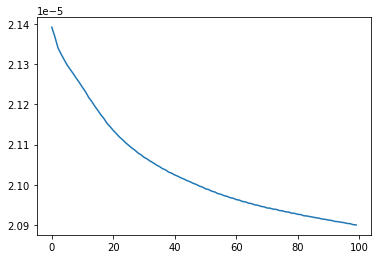

In [15]:
history_supervised.plot_scalar('loss_nmf')
#history_supervised.plot_scalar('loss')

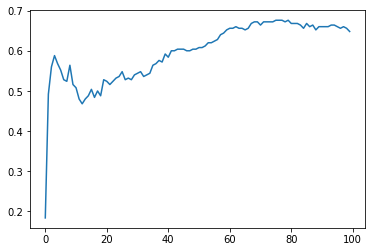

In [16]:
plt.plot(layer2_acc_test)

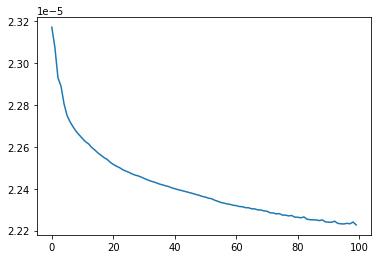

In [17]:
history_supervised.plot_scalar('loss_classification')

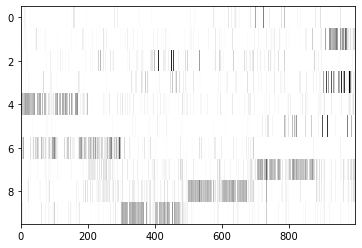

In [18]:
history_supervised.plot_tensor('S1', [-1])

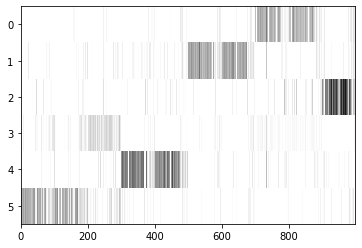

In [19]:
history_supervised.plot_tensor('S2',[-1])

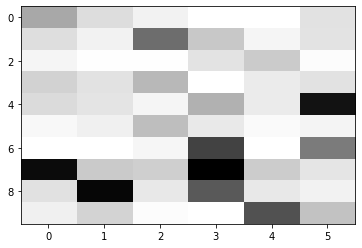

In [20]:
history_supervised.plot_tensor('A2', [-1])

In [21]:
#calculate reconstruction error
layer1_error = torch.norm(X - torch.mm(A1, S1))
layer2_error = torch.norm(X - torch.mm(torch.mm(A1, A2), S2))

print("Layer 1 error...    " + str(layer1_error))
print("Layer 2 error...    " + str(layer2_error))

Layer 1 error...    tensor(30.8281, dtype=torch.float64)
Layer 2 error...    tensor(30.9798, dtype=torch.float64)


In [22]:
keywords = np.empty((12,10), dtype=object)

for i in range(keywords.shape[1]):
    keywords[0,i] = "Topic " + str(i+1)
    keywords[1,i] = "-------"

for i in range(results['A1'].shape[1]):
    col = results['A1'][:,i]*7/6 -  np.mean(results['A1'], axis=1)
    top = col.argsort()
    top = top[-10:][::-1]

    keywords[2:,i] = idx_to_word[top] 

print("RANK 10 KEYWORDS:")  
print("------------------")
col_widths = [max([len(keywords[i][j]) for i in range(keywords.shape[0])])+2 for j in range(keywords.shape[1])]
for row in keywords:
    print("".join(row[i].ljust(col_widths[i]) for i in range(0,5)))
print("")
for row in keywords:
    print("".join(row[i].ljust(col_widths[i]) for i in range(5,10)))


keywords = np.empty((12,6), dtype=object)

for i in range(keywords.shape[1]):
    keywords[0,i] = "Topic " + str(i+1)
    keywords[1,i] = "-------"

A = results['A1'] @ results['A2']
for i in range(A.shape[1]):
    col = A[:,i]*7/6 -  np.mean(A, axis=1)
    top = col.argsort()
    top = top[-10:][::-1]

    keywords[2:,i] = idx_to_word[top] 

print("RANK 6 KEYWORDS:")  
print("------------------")
col_widths = [max([len(keywords[i][j]) for i in range(keywords.shape[0])])+2 for j in range(keywords.shape[1])]
for row in keywords:
    print("".join(row[i].ljust(col_widths[i]) for i in range(len(row))))


RANK 10 KEYWORDS:
------------------
Topic 1     Topic 2   Topic 3    Topic 4   Topic 5     
-------     -------   -------    -------   -------     
gun         sale      geb        drive     bike        
people      offer     banks      apple     dod         
armenians   drive     gordon     mhz       motorcycle  
fbi         new       pitt       video     games       
us          shipping  shameful   graphics  got         
guns        mb        njxp       card      helmet      
turkish     computer  intellect  mac       stadium     
government  sell      dsl        know      year        
turkey      best      cadre      sound     baseball    
armenian    color     chastity   mb        last        

Topic 6  Topic 7   Topic 8     Topic 9      Topic 10     
-------  -------   -------     -------      -------      
space    israel    responses   people       jesus        
know     arab      posting     rosicrucian  god          
centaur  israeli   others      cockroaches  christians   
